# Building Segmentation
### The Challenge
To demonstrate how easy it is to use Moonshine, we show an example of how to solve the [SpaceNet 1: Building Detection](https://spacenet.ai/spacenet-buildings-dataset-v1/) challenge. The data and labels were provided by the SpaceNet foundation, and contains ~6400 image tiles from the WorldView-2 satellite with 1m resolution in 8 bands (see [their paper](https://arxiv.org/abs/1807.01232) for more technical details). 

<div><br>
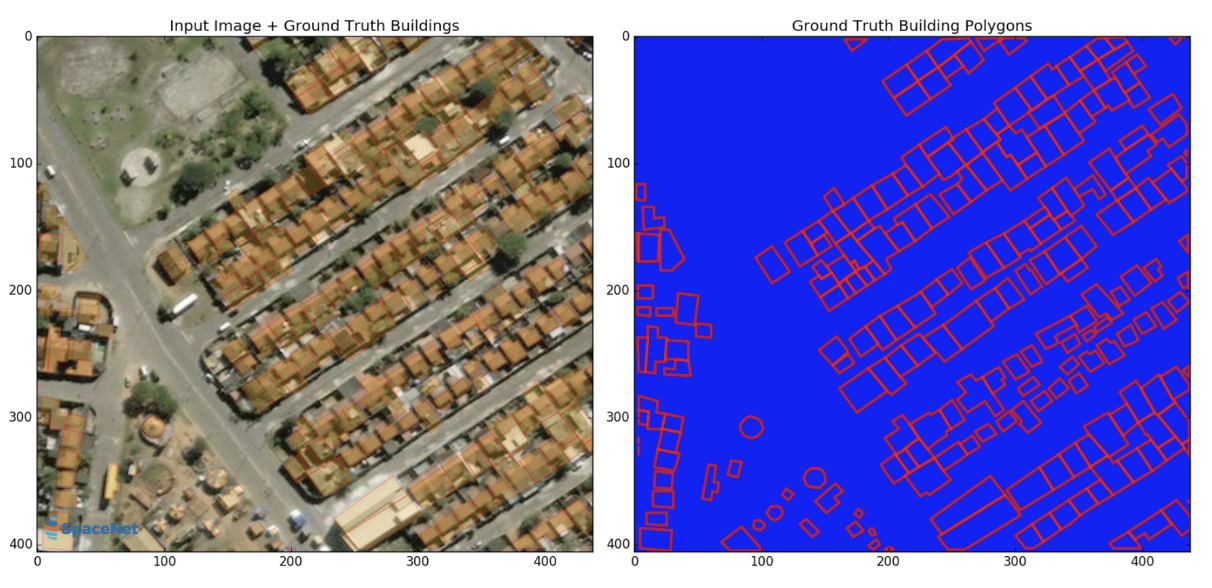
</div>

In each image tile, SpaceNet provides a set of building instance labels in `geojson` format. We convert these labels into a dense segmentation mask, and provide this preprocessing code along with this example.

### The Solution
This example uses PyTorch and Moonshine to train a UNet network with a ResNet-50 backbone that does semantic segmentation of high resolution satellite images into "building" and "not building" classes. We use PyTorch Lightning as a training framework, and the Albumentations package for data augmentation since generic PyTorch data augmentation does not easily support transforming the mask with the image. We train our network for 50 epochs with minimal data augmentation (simple horizontal/vertical flipping) using the Adam optimizer.

### The Code
Our solution below demonstrates how easy it is to get started with Moonshine. The vast majority of the code is the DataPipe and DataLoader code, as well as the trainer class implementation. **Enabling pre-trained weights is as simple as a single line of code.**

While we can use existing pre-trained weights from ImageNet or similar packages when we have RGB data, working with full multispectral data means previously learned weights from standard computer vision datasets won't work. Moonshine is unique in providing multispectral pre-trained networks.

## Get the Data
The dataset for this challenge is approximately 2GB, and processing the data to create the masks will take maybe an hour depending on the speed of your machine.

In [ ]:
# Install requirements
!pip install -r requirements.txt

# Download the tiles
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz .
!tar xvf SN1_buildings_train_AOI_1_Rio_8band.tar.gz 

# Download the labels
!aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz .
!tar xvf SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz 

# Create the masks
!mkdir mask
!python generate_masks.py ./

## Imports

In [ ]:
# We've opted to include type annotations on some functions, but for brevity
# do not include them everywhere.
from typing import Any, Sequence, Union, Optional

import glob
import random
import os
import functools

import numpy as np
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch

torch.set_float32_matmul_precision("high")
import torchdata.datapipes as dp
from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

# We broke a few functions out to their own file. In general this is
# good practice with notebooks.
from utils import label_from_8band, read_tile, one_hot_3d

## DataPipe
In order to load the dataset, we'll use a somewhat recent API in PyTorch called [DataPipes](https://pytorch.org/data/main/torchdata.datapipes.iter.html). The `DataPipes` API allows us to generate a dataset in a functional manner, similar to the `tf.data` API. We don't need to do much here, but it is important that we preprocess the data to make it suitable for the Moonshine model. For the model we are using, the preprocessing is performing simple mean/var standardization.

We also have to accept multiple different transforms, one for the image and one for the mask. This is because the mask transform needs to use a different resizing method from the image.

In [ ]:
from moonshine.preprocessing import get_preprocessing_fn


def read_item(path: str) -> tuple[np.ndarray, np.ndarray]:
    """Read the image and the label mask from a path."""
    fn = get_preprocessing_fn(model="unet", dataset="fmow_full")
    data, _ = read_tile(path)
    data = fn(data)
    data = data.astype(np.float32)

    mask_path = label_from_8band(path, label_type="mask")
    mask = np.load(mask_path).astype(np.uint8)
    mask = one_hot_3d(mask, num_classes=2)

    return data, mask


def remove_missing(path: str) -> bool:
    """If we are missing a label mask file, we'll skip that example."""
    mask_path = label_from_8band(path, label_type="mask")
    if os.path.exists(mask_path):
        return True
    return False


def apply_transforms(row, transform):
    """Apply the PyTorch transforms for the DataPipe."""
    tfx = transform(image=row[0], mask=row[1])
    return tfx["image"], tfx["mask"]


def building_footprint_datapipe(files, transform):
    """Create the DataPipe for a set of files."""
    print(f"Got {len(files)} files for this dataset")

    datapipe = dp.iter.IterableWrapper(files)
    datapipe = datapipe.filter(remove_missing)
    datapipe = datapipe.sharding_filter()
    datapipe = datapipe.map(read_item)

    if transform:
        transform_fx = functools.partial(
            apply_transforms,
            transform=transform
        )
        datapipe = datapipe.map(transform_fx)

    return datapipe

## DataLoader
We create a `DataLoader` for our dataset using the datapipe above. This code will also do our train/val splitting. With such a small dataset, it may be better in a production setting to do multifold cross-validation, but for this proof of concept a simple split will be okay.

Also note that for many applications of remote sensing, you may want to be careful with how you split your data. For example, you may want to take into account location (i.e. split by country, etc) and time (i.e. don't include revisited tiles). AGain, for our proof of concept we will do a simple split.

In [ ]:
def train_test_split(
    files: Sequence[str], train_percent: float = 0.8
) -> tuple[list, list]:
    """Very simple train test split, shuffling has a hard coded seed."""
    random.seed(1234)
    total = len(files)
    n_train = int(total * train_percent)
    random.shuffle(files)

    return files[0:n_train], files[n_train:]


def get_dataset(files: Sequence[str], split: str = "train") -> DataLoader:
    """Create a dataset for building footprint classification."""
    tfx = [
        A.RandomCrop(width=96, height=96),
    ]
    train_tfx = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
    ]
    
    if split == "train":
        tfx.extend(train_tfx)
    tfx.append(ToTensorV2(transpose_mask=True))
        
    datapipe = building_footprint_datapipe(
        files,
        transform=A.Compose(tfx),
    )

    return DataLoader(
        dataset=datapipe,
        batch_size=16,
        shuffle=(split == "train"),
        drop_last=True,
        num_workers=4,
        pin_memory=True,
    )

## Model 
Our model is very simple to create using Moonshine! We will use a [UNet50 model](https://moonshineai.readthedocs.io/en/latest/models.html#resnet50-fmow-full) that's designed to be used on the [WorldView](https://earth.esa.int/eogateway/missions/worldview) satellite series. The model can be initialized from scratch, or loaded with pretrained weights from Moonshine's task-agnostic pretraining.

In [ ]:
from moonshine.models.unet import UNet


class BuildingClassifier(torch.nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()

        # Create a blank model based on the available architectures.
        self.backbone = UNet(name="unet50_fmow_full")

        # If we are using pretrained weights, load them here. In
        # general, using the decoder weights isn't preferred unless
        # your downstream task is also a reconstruction task. We suggest
        # trying only the encoder first.
        if pretrained:
            self.backbone.load_weights(
                encoder_weights="unet50_fmow_full", decoder_weights=None
            )

        # Run a per-pixel classifier on top of the output vectors.
        self.classifier = torch.nn.Conv2d(32, 2, (1, 1))

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

## Trainer
We are using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/) to simpify the training process. The trainer code is vanilla, with a per-pixel IoU metric as our target metric and Adam optimization.

In [ ]:
class BuildingTrainer(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.jaccard = JaccardIndex(task="multiclass", num_classes=2)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)

        loss = torch.nn.functional.cross_entropy(y_hat, y)
        iou = self.jaccard(y_hat, y[:, 1, :, :])
        self.log("train/loss", loss, on_epoch=True, prog_bar=True)
        self.log("train/iou", iou, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)

        loss = torch.nn.functional.cross_entropy(y_hat, y)
        iou = self.jaccard(y_hat, y[:, 1, :, :])
        self.log("val/loss", loss, on_epoch=True, prog_bar=True)
        self.log("val/iou", iou, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

## Putting It All Together


In [ ]:
DATA_PATH = "/home/nharada/Datasets/spacenet_1_buildings/"


def run_experiment(pretrain=False):
    """Run an experiment with or without pretraining"""
    # Download the files into a folder with 8band and geojson subfolders.
    files = glob.glob(os.path.join(DATA_PATH, "8band/*.tif"))

    # Create a name for Tensorboard
    pretrain_key = "pretrained" if pretrain else "scratch"
    exp_name = f"building_model_both_{pretrain_key}"

    # Create our datasets.
    train_files, val_files = train_test_split(files)
    train_dataset = get_dataset(train_files, split="train")
    val_dataset = get_dataset(val_files, split="val")

    # We'll use Tensorboard to log our experiments, but this is optional.
    logger = pl.loggers.TensorBoardLogger("tb_logs", name=exp_name)
    trainer = pl.Trainer(
        accelerator="auto",
        max_epochs=50,
        enable_progress_bar=True,
        logger=logger,
    )

    # We'll use the custom lightning trainer, confusingly called a model by the lightning API.
    model = BuildingClassifier(pretrained=pretrain)
    pytrain = BuildingTrainer(model)

    # Train!
    trainer.fit(
        model=pytrain,
        train_dataloaders=train_dataset,
        val_dataloaders=val_dataset,
    )


print("Run experiment without pretraining")
run_experiment(pretrain=False)
print("Run experiment with pretraining")
run_experiment(pretrain=True)

## Results
Once your models have trained, you can open Tensorboard to see the training curves and results.

<div><br>
<p style="text-align:center;">
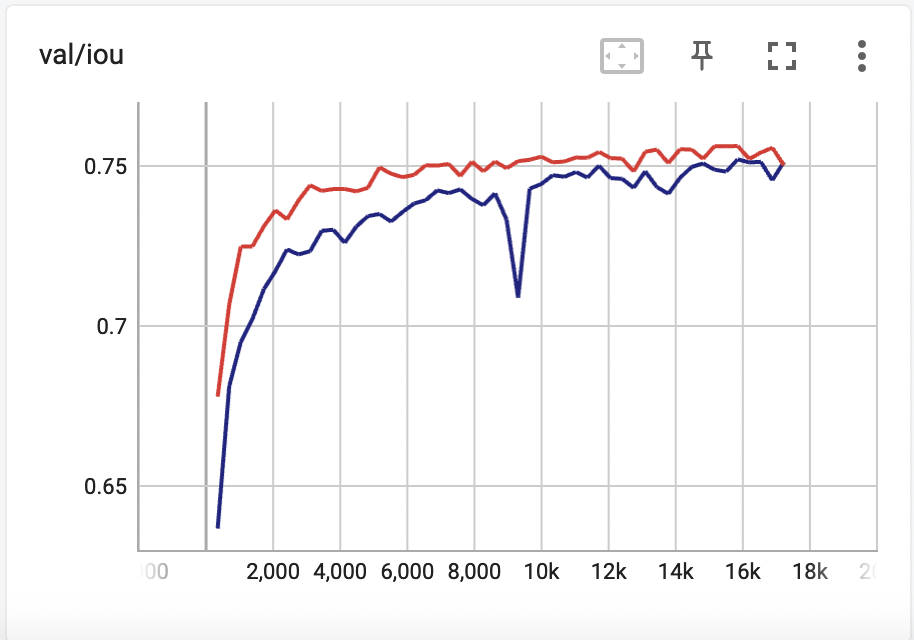
</p>
</div>

In the above plot, the dark blue line is our model trained from scratch, while the red is trained using the pretrained Moonshine weights. You can see that starting from pre-trained weights both converges faster and to a higher level of performance than training from scratch.